In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from flosp.aggregation import count_hourly_occupancy, get_datetimes_list_all

In [2]:
ED = pd.read_pickle('./../../data/raw/cleanED.pkl')

In [3]:
ED.head(2)

,pseudo_patient_number,attendance_number,age,gender,site_attended,arrive_datetime,arrival_mode,arrival_mode_desc,1st_time_triaged_[datetime],1st_time_seen_by_doctor,...,time_of_speciality_referral,speciality_referred_to,time_into_cdu,depart_datetime,majorsminorsresus_patient,triage_category,flag_admission,flag_bedreq,flag_specreq,flag_cdu
0,004101045105,90902325901,94,0,Main ED,2009-04-13 09:16:00,NaN,BROUGHT IN BY AMBULANCE,NaN,2009-04-13 10:28:00,...,NaT,NaN,NaT,2009-04-13 12:24:00,Majors,VERY URGENT,0,1,1,1
1,644868441371,90902326101,47,1,Main ED,2009-04-13 09:22:00,NaN,BROUGHT IN BY AMBULANCE,NaN,2009-04-13 09:30:00,...,NaT,NaN,NaT,2009-04-13 12:55:00,Majors,VERY URGENT,1,1,1,1


In [4]:
ED.columns

Index(['pseudo_patient_number', 'attendance_number', 'age', 'gender',
       'site_attended', 'arrive_datetime', 'arrival_mode', 'arrival_mode_desc',
       '1st_time_triaged_[datetime]', '1st_time_seen_by_doctor',
       'time_of_inpatient_bed_request', 'time_of_speciality_referral',
       'speciality_referred_to', 'time_into_cdu', 'depart_datetime',
       'majorsminorsresus_patient', 'triage_category', 'flag_admission',
       'flag_bedreq', 'flag_specreq', 'flag_cdu'],
      dtype='object')

#### get the hourly ED occupancy

EDocc = count_hourly_occupancy(ED,'arrival','time_leaving_dept_inc_cdu','EDocc')

EDocc.to_pickle('./EDocc.pkl')

In [5]:
def select_records_at_instance(df, datetime, start_col, end_col):
    """
    Takes df and selects only records active at a datetime.
    
    Return
    ======
    sample, dataframe , with only records which are of interest.
    
    """
#     sample = df[(df[start_col] <= datetime) & (df[end_col] >= datetime)]
    # new sampling added to include the patients who are still in the hospital and hence have no discharge/departure time.
    sample = df[((df[start_col] <= datetime) & (df[end_col] >= datetime)) | ((df[start_col] <= datetime) & (df[end_col].isnull()))]
    return(sample)

def ED_instance_calcs(df_sample):
    """
    Make calculations for records at the time.
    """
    calcs = {}
    calcs['occupancy'] = len(df_sample) # no attendances
#     calcs['age_mean'] = df_sample['age'].mean()
#     calcs['age_75plus'] = len(df_sample[df_sample.age >= 75])
    
    return(calcs)

def get_instance_df(df, datetimes, df_type):
    """
    Calculate daily features from patient level records.
    
    Input
    =====
    df, dateframe, patient level records.
    datetimes, DateTimeIndex, datetime index of each date features are required for. 
    
    Return
    ======
    
    
    """
    if df_type == 'ED':
        calculation_function = ED_instance_calcs
        col_dict = calculation_function(df) # run function once to get list of columns names
        daily_features_columns = list(col_dict.keys())
        select_records_columns = ['arrive_datetime','depart_datetime'] # for use in select_records_in_period function
        
    elif df_type == 'IP':
        calculation_function = IP_instance_calcs
        col_dict = calculation_function(df) # run function once to get list of columns names
        daily_features_columns = list(col_dict.keys())
        select_records_columns = ['adm_datetime','dis_datetime']
    
    #### setup new df for results
    instance_features = pd.DataFrame(index=datetimes, columns = daily_features_columns)
    
    #### loop over all records
    for start_date in datetimes:
        #### get records
#         print(start_date)
#         end_date = start_date + pd.Timedelta(1, 'd') # cal enddate (1 day behind) - hence will create records based on what happened in the 24 hours of the day.
        selected_records = select_records_at_instance(df, start_date, select_records_columns[0], select_records_columns[1]) # get records for this periods
        
        #### calculate values
        day_calcs = calculation_function(selected_records)
        
        #### assign to dataframe
        
        instance_features.loc[start_date] = pd.Series(day_calcs) #, inplace=True)#[start_date, 'test'] = 5
    
    return(instance_features)

# time = pd.datetime(2016,11,5,3)
# select_records_at_time(ED, time, 'arrive_datetime', 'depart_datetime')[['arrive_datetime','depart_datetime']]

#### get timeindex to iterate over

In [6]:
start = pd.datetime(2009, 4, 1)
end = pd.datetime(2018, 9, 30)
datetime_index_hours = pd.date_range(start=start, end=end, freq='h')
datetime_index_hours

DatetimeIndex(['2009-04-01 00:00:00', '2009-04-01 01:00:00',
               '2009-04-01 02:00:00', '2009-04-01 03:00:00',
               '2009-04-01 04:00:00', '2009-04-01 05:00:00',
               '2009-04-01 06:00:00', '2009-04-01 07:00:00',
               '2009-04-01 08:00:00', '2009-04-01 09:00:00',
               ...
               '2018-09-29 15:00:00', '2018-09-29 16:00:00',
               '2018-09-29 17:00:00', '2018-09-29 18:00:00',
               '2018-09-29 19:00:00', '2018-09-29 20:00:00',
               '2018-09-29 21:00:00', '2018-09-29 22:00:00',
               '2018-09-29 23:00:00', '2018-09-30 00:00:00'],
              dtype='datetime64[ns]', length=83257, freq='H')

In [9]:
EDinstance = get_instance_df(ED, datetime_index_hours, 'ED')

In [10]:
EDinstance.tail()

,occupancy
2018-09-29 20:00:00,46
2018-09-29 21:00:00,58
2018-09-29 22:00:00,54
2018-09-29 23:00:00,55
2018-09-30 00:00:00,57


#### save data out

In [11]:
EDinstance.to_pickle('./../../data/interim/D3_dailyTS/EDhourly_occupancy.pkl')

In [ ]:
break

## get daily dataframe

In [8]:
from flosp.basic_tools import make_callender_columns

In [9]:
EDocc['dt_date'] = EDocc.index

In [10]:
pd.datetime(2018,1,1,11).replace(hour=0)

datetime.datetime(2018, 1, 1, 0, 0)

In [11]:
EDocc['dt_date'] = EDocc.dt_date.apply(lambda x : x.replace(hour=0))

In [12]:
occD = pd.DataFrame(EDocc.groupby(['dt_date']).mean()['EDocc'])

In [13]:
occD.head(2)

,EDocc
dt_date,
2009-04-01,28.208333
2009-04-02,36.625000


# flag outlier function 

----------------------------------------
Making callender columns from:  date


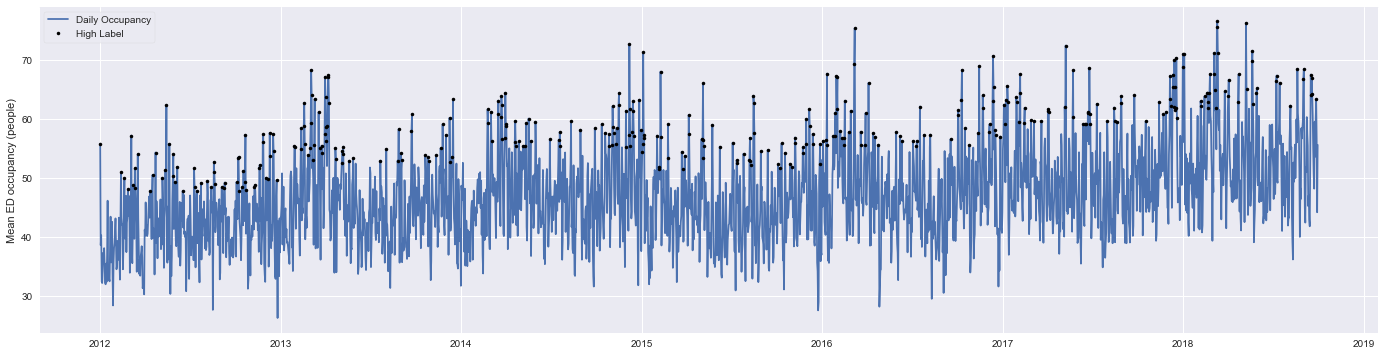

In [29]:
from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(24,6))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
        ax.legend(['Daily Occupancy','High Label'],frameon=True,loc='upper left')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(occD,'EDocc',0.85,True,[2012,2013,2014,2015,2016,2017,2018])

----------------------------------------
Making callender columns from:  date


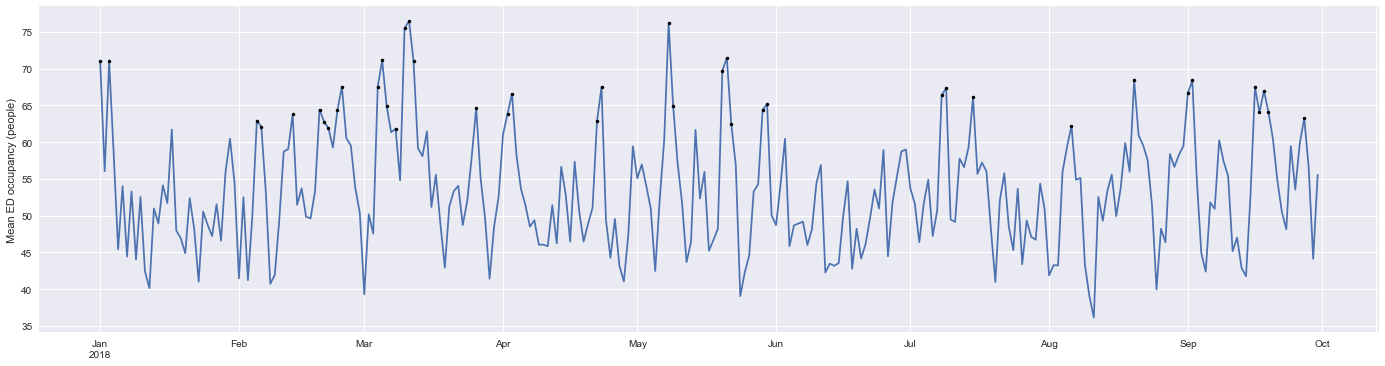

In [30]:
from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(24,6))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(occD,'EDocc',0.85,True,[2018])

----------------------------------------
Making callender columns from:  date


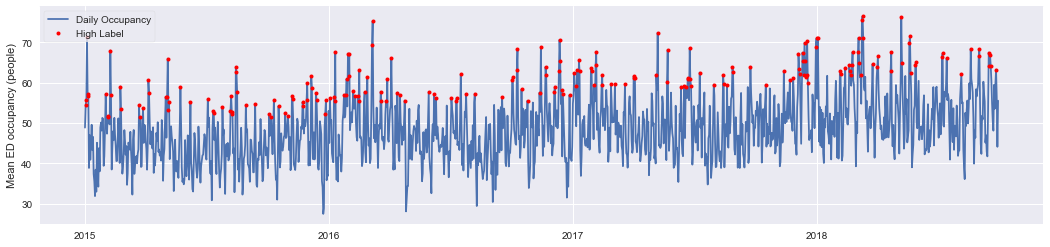

In [39]:
from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(18,4))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.r',ms=8)
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
        ax.legend(['Daily Occupancy','High Label'],frameon=True,loc='upper left')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(occD,'EDocc',0.85,True,[2015,2016,2017,2018])

In [26]:
dff = df.loc[(df.index >= '2012-1-1')]

In [27]:
dff.to_pickle('./EDooc_class.pkl')

# Dev 

In [6]:
break

SyntaxError: 'break' outside loop (<ipython-input-6-6aaf1f276005>, line 1)

In [27]:
df['datetime'] = df.index

In [30]:
df = make_callender_columns(df,'datetime','dt')

----------------------------------------
Making callender columns from:  datetime


In [33]:
df = df.query('dt_year >= 2012')

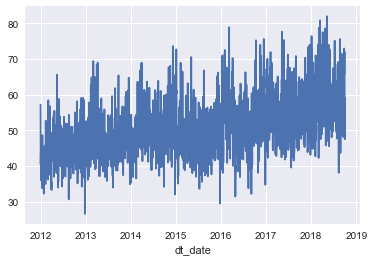

In [36]:
df.groupby(['dt_date']).mean()['EDocc'].plot()

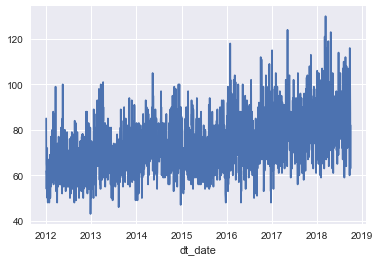

In [37]:
df.groupby(['dt_date']).max()['EDocc'].plot()

In [38]:
df.groupby(['dt_date']).mean()['EDocc'].describe()

count    2465.000000
mean       50.926640
std         8.143732
min        26.541667
25%        45.291667
50%        50.166667
75%        55.791667
max        82.000000
Name: EDocc, dtype: float64

In [39]:
df.groupby(['dt_date']).max()['EDocc'].describe()

count    2465.000000
mean       73.701014
std        11.719750
min        43.000000
25%        65.000000
50%        73.000000
75%        81.000000
max       130.000000
Name: EDocc, dtype: float64

In [48]:
occD = pd.DataFrame(df.groupby(['dt_date']).mean()['EDocc'])

In [49]:
occD.head()

,EDocc
dt_date,
2012-01-01,57.166667
2012-01-02,40.458333
2012-01-03,43.625000
2012-01-04,36.291667
2012-01-05,36.000000


In [50]:
occD['date'] = occD.index

In [51]:
occD.head(2)

,EDocc,date
dt_date,,
2012-01-01,57.166667,2012-01-01
2012-01-02,40.458333,2012-01-02


In [54]:
occD['date'] = pd.to_datetime(occD['date'])

occD = make_callender_columns(occD,'date','d')

In [56]:
occD.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend
dt_date,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0


In [78]:
year_describe = pd.DataFrame(occD.groupby(['d_year']).quantile(0.85)['EDocc']).rename(columns={'EDocc':'quantile'})
year_describe

,quantile
d_year,
2012,50.760417
2013,55.116667
2014,58.416667
2015,55.475000
2016,59.177083
2017,63.341667
2018,68.425000


In [79]:
occD_yearly = occD.merge(year_describe,left_on='d_year',right_index=True)
occD_yearly.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend,quantile
dt_date,,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1,50.760417
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0,50.760417
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0,50.760417
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0,50.760417
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0,50.760417


In [80]:
occD_yearly['flag'] = occD_yearly.apply(lambda x : x.EDocc > x['quantile'], axis=1).astype(int)

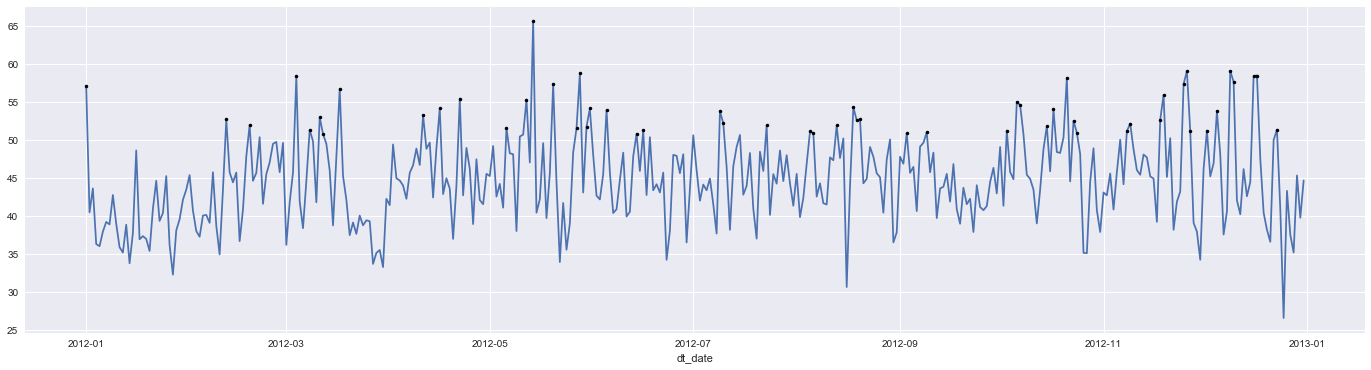

In [93]:
dff = occD_yearly.query('d_year == 2012')

target_col = 'EDocc'

fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))

dff[dff.flag == 1][target_col].plot(ax=ax,style='.k')